# A brief (but painful) intro to ``FloPy``

### Here we will load an existing USGS groundwater model, update the file structure, write new input files, rerun the model and export the inputs and outputs

In [1]:
%matplotlib inline
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

print(sys.version)
print('python installation location: {}'.format(os.path.dirname(sys.executable)))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
python installation location: /Users/jwhite/anaconda/bin
numpy version: 1.11.1
matplotlib version: 1.5.1
flopy version: 3.2.7


The ``path`` to the original model files

In [2]:
org_model_ws = os.path.join("hagm_nosub")
assert os.path.exists(org_model_ws)

You need to point to the location in your file structure to MODFLOW 2005

In [3]:
exe_name = "mf2005"

## Load the existing model with ``FloPy``

In [4]:
m = flopy.modflow.Modflow.load("HAGM.2013.nam",
                               model_ws=org_model_ws,
                               exe_name=exe_name,
                              verbose=False)

/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:226: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


## Processing model inputs
Once the model is in memory, ``FloPy`` exposes several built-in methods a al ``pandas``

In [5]:
m.dis.export(m.name+".dis.shp")

In [6]:
m.export(m.name+".nc")

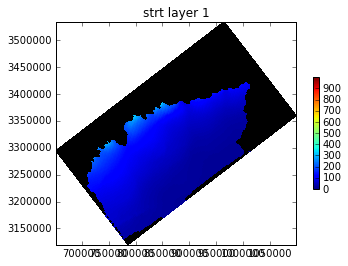

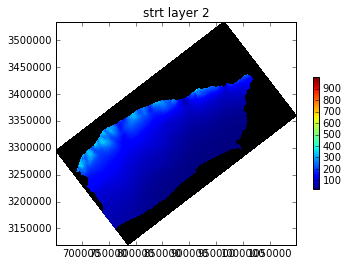

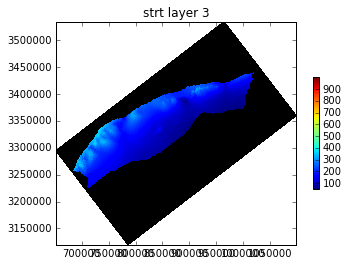

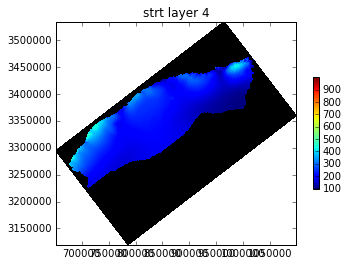

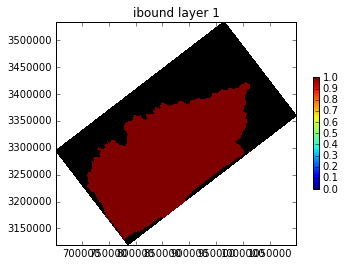

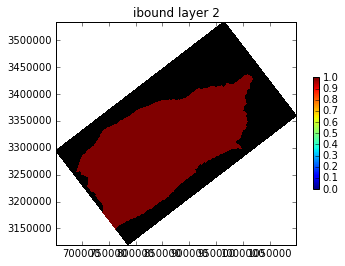

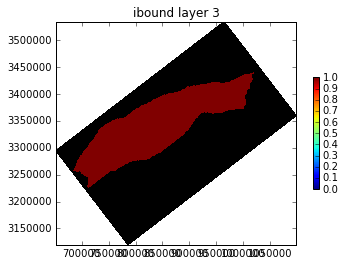

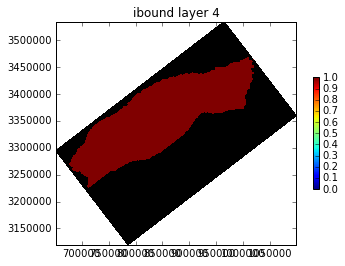

In [7]:
m.bas6.plot()

Some modern MODFLOW options:

In [8]:
m.array_free_format = True
m.bas6.ifrefm = True
m.remove_external("ddn")


Any additional modifications can be made here...like a scenario?

## Change the model work space, write new input files and re-run

In [9]:
base_model_ws = "base"
m.change_model_ws(base_model_ws,reset_external=True)



creating model workspace...
   base

changing model workspace...
   base


In [10]:
m.write_input()

In [11]:
m.run_model()

FloPy is using the following executable to run the model: /Users/jwhite/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: HAGM.2013.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/07/10 14:25:40

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Groun

(True, [])

## Output processing

We can process the MODFLOW ``lst`` file for global water budget info

In [12]:

mflist = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".lst"))

In [13]:
flx,vol = mflist.get_dataframes(start_datetime=m.start_datetime,diff=True)

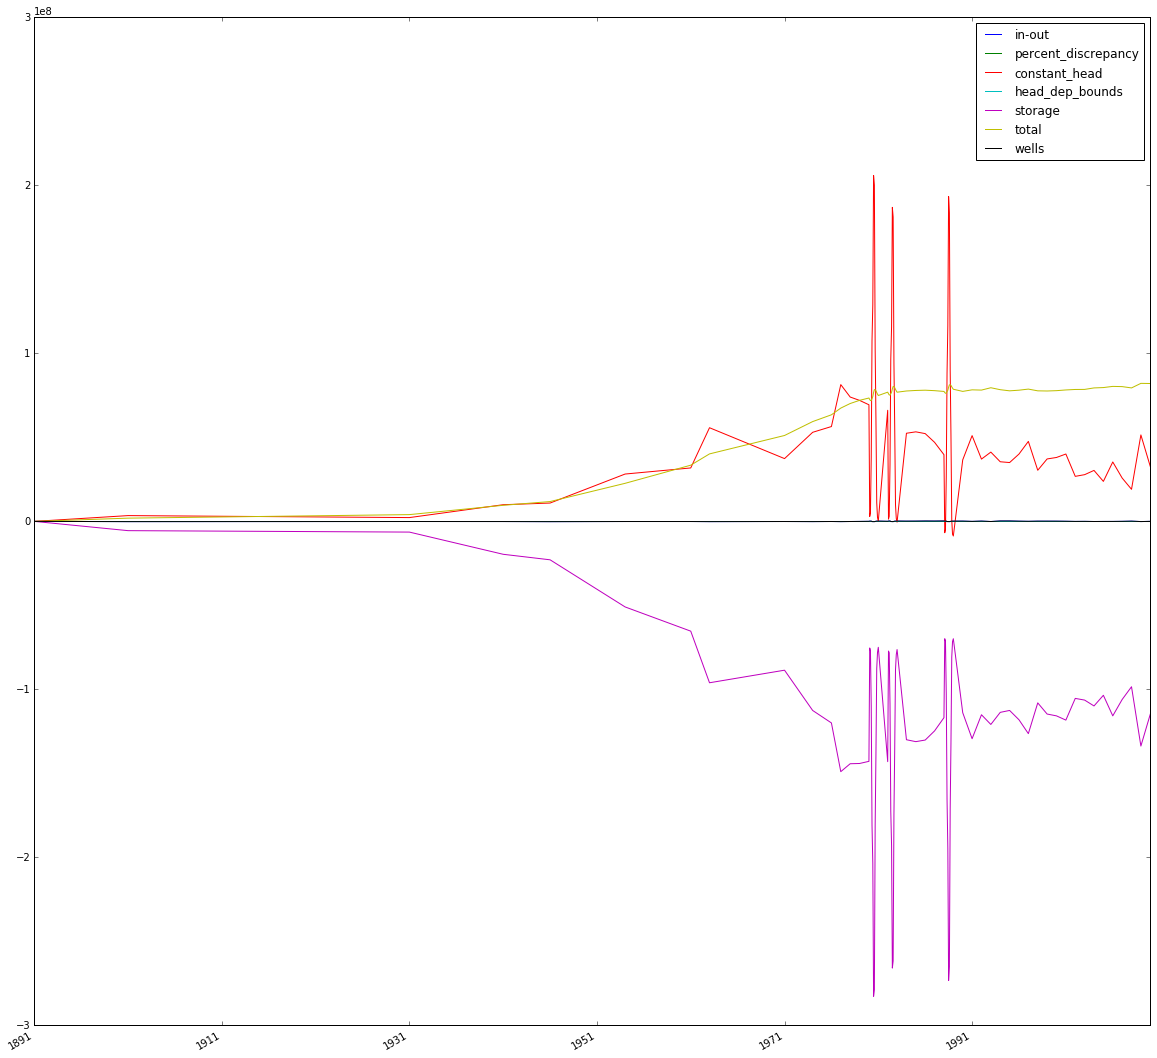

In [14]:
flx.plot(figsize=(20,20))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x126445898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x126e6ada0>], dtype=object)

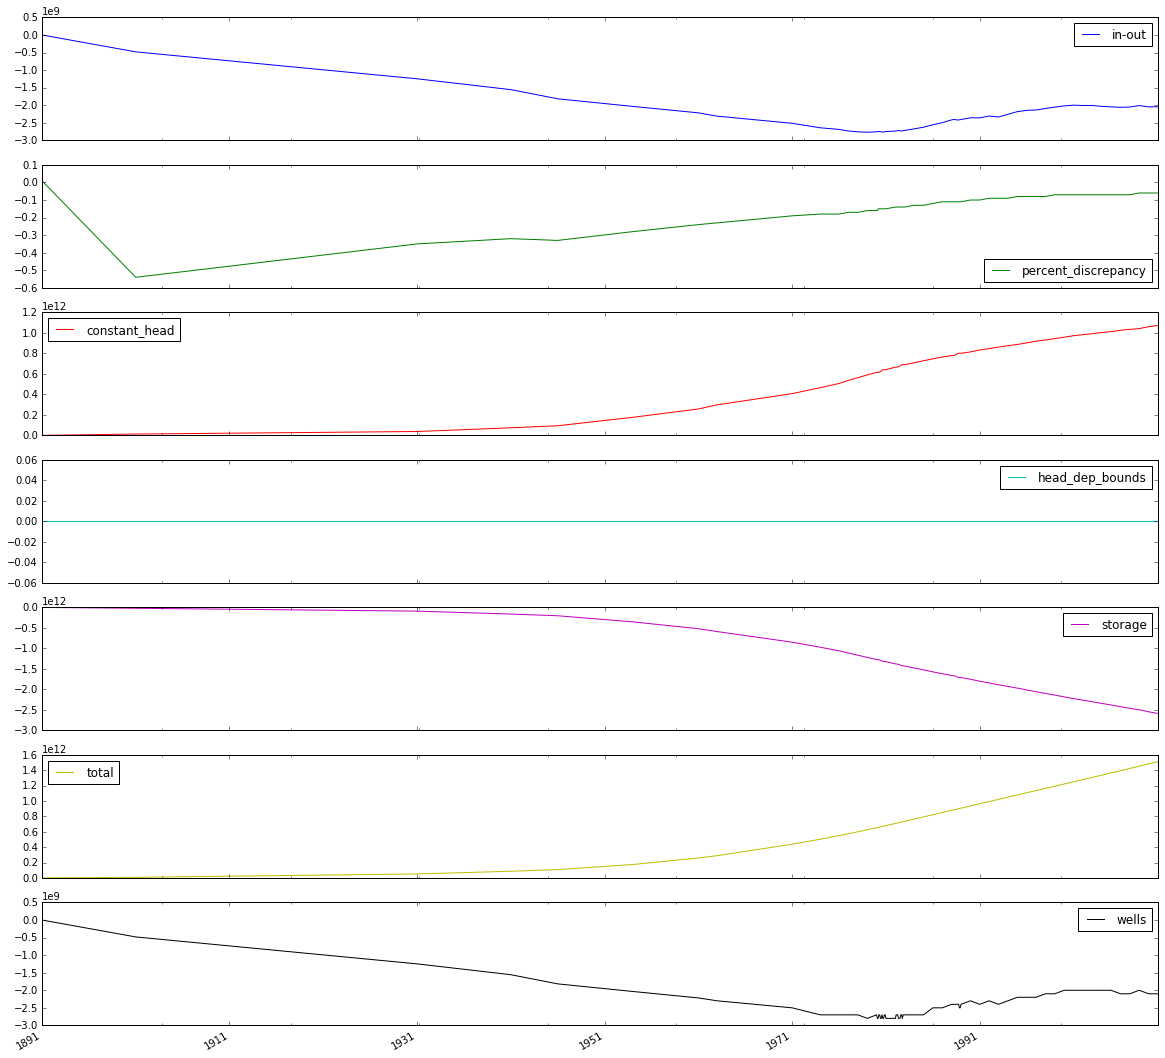

In [15]:
vol.plot(figsize=(20,20),subplots=True)

## binary output processing

In [16]:
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
hds.times[:5]

[1.0, 3653.5, 14611.0, 18263.5, 20089.75]

The ``HeadFile`` object exposes lots of nice options for post-processing

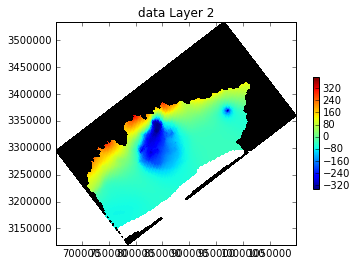

In [17]:
hds.plot(totim=hds.times[-1],mflay=1,colorbar=True)

In [18]:
hds.to_shapefile(m.name+".hds.shp",totim=hds.times[5])

In [19]:
data = hds.get_data()

In [20]:
flopy.export.utils.output_helper(m.name+".hds.nc",m,{"hds":hds})